# Captcha Solver

In [0]:
import cv2
import keras
import numpy as np
from matplotlib import pyplot as plt

In [0]:
%%capture
!unzip generated_captcha_images.zip

## Data Processing

### Extracting Single letters from Captcha.

In [0]:
import os 
import os.path, glob, imutils

In [0]:
captcha_image_folder = "generated_captcha_images"
output_folder = "extracted_letter_images"

In [0]:
# Getting a list of all the captcha images we need to process
captcha_image_files = glob.glob(os.path.join(captcha_image_folder,'*'))

In [0]:
counts = {}

In [0]:
# loop over the image paths
for i,image_file in enumerate(captcha_image_files):
    print("[INFO] processing image {}/{}".format(i + 1, len(captcha_image_files)))
    
    # grab the base filename as the text
    file_name = os.path.basename(image_file)
    correct_text = os.path.splitext(file_name)[0]
    
    # Load the image
    image = cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)
    
    # Addding some extra padding around the image
    image = cv2.copyMakeBorder(image,8,8,8,8,cv2.BORDER_REPLICATE)
    
    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    #Finding the contours
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    contours = contours[0] if imutils.is_cv2() else contours[1]
    letter_image_regions = []
    
    # Now we can loop through each of the four contours and extract the letter inside of each one
    for contour in contours:
        
        (x,y,w,h) = cv2.boundingRect(contour)
        if h == 0:
            print(x,y,w,h)
        if w/h > 1.25:
            
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            
            half_width = int(w/2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
            
        else:
            letter_image_regions.append((x,y,w,h))
            
    if len(letter_image_regions)>4:
        continue
    
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    
    for box,text in zip(letter_image_regions, correct_text):
        
        (x,y,w,h) = box
        
        letter_image = image[y-2: y+h+2,x-2:x+w+2]
        saving_path = os.path.join(output_folder,text)
        
        # If the folder doesn't exists make it
        if not os.path.exists(saving_path):
            os.makedirs(saving_path)
        count = counts.get(text,1)
        
        # Writing image to file
        p = os.path.join(saving_path,f'{str(count).zfill(6)}.png')
        cv2.imwrite(p,letter_image)        
        counts[text]= count + 1

In [0]:
for i,j in counts.items():
    print(f'{i}: {j}',end= ' ')

R: 1228 B: 1204 5: 1235 M: 1197 E: 1264 F: 1182 X: 1210 Y: 1224 Z: 1232 D: 1200 W: 1194 4: 1202 U: 1206 6: 1167 2: 1209 8: 1216 3: 1210 T: 1224 N: 1252 Q: 1217 J: 1139 G: 1228 L: 1202 V: 1159 P: 1248 K: 1225 H: 1227 7: 1285 C: 1204 9: 1359 S: 1232 A: 1193 

In [0]:
mapping = {'A': 8, 'B': 9, 'C': 10, 'D': 11, 'E': 12, 'F': 13, 'G': 14,
           'H': 15, 'J': 16, 'K': 17, 'L': 18, 'M': 19, 'N': 20, 'P': 21, 
           'Q': 22, 'R': 23, 'S': 24, 'T': 25, 'U': 26,'V': 27, 'W': 28,
           'X': 29, 'Y': 30, 'Z': 31, '2':0,'3': 1, '4': 2,'5': 3, '6':4,
           '7': 5,'8': 6,
           '9': 7}

## Building and Training model

### Making training and validation data

In [0]:
base_filename = 'extracted_letter_images'
y = np.array([])
len_letter = []
images = []
for folder in os.listdir(base_filename):
    Subdir = os.path.join(base_filename,folder)
    file_names = glob.glob( os.path.join( Subdir, '*' ))
    n_files = len(file_names)
    len_letter.append(n_files)
    label = mapping[folder]
    labels = np.full(n_files,label)
    
    if y.shape == (0,):
        y = labels
    else:
        y = np.append(y,labels)
    
    for name in file_names:
        image = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
        images.append(image)

#### Resizing images

In [0]:
img_width, img_height = 20, 20

resized_images = [cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in images]


In [0]:
np.array(resized_images[0]).shape

(20, 20)

In [0]:
y.shape

(38942,)

### Splitting Data into training and validation

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Flatten,MaxPooling2D,Dropout

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(np.array(resized_images),y, train_size=0.8, test_size=0.2)

X_train = X_train.reshape(len(X_train),20,20,1).astype('float32')
X_test = X_test.reshape(len(X_test),20,20,1).astype('float32')

y_train = keras.utils.to_categorical(y_train, 32)
y_test = keras.utils.to_categorical(y_test, 32)

In [0]:
len(X_train), len(y_train)

(31153, 31153)

In [0]:
len(X_test), len(y_test)

(7789, 7789)

### Building Model

In [0]:
model = Sequential()

In [0]:
model.add(Conv2D(32,(3,3),input_shape = (20,20,1),activation = 'relu', name = 'Conv2D_1'))
model.add(Conv2D(32,(3,3),activation = 'relu', name = 'Conv2D_2'))
model.add(MaxPooling2D(pool_size=(2, 2), name = 'MaxPool2D_1'))
model.add(Dropout(0.25, name = 'Dropout_1'))

model.add(Conv2D(64,(3,3),activation = 'relu', name = 'Conv2d_3'))
model.add(Conv2D(64,(3,3),activation = 'relu', name = 'Conv2d_4'))
model.add(MaxPooling2D(pool_size=(2, 2), name = 'MaxPool2D_2'))
model.add(Flatten(name = 'Flatten'))

model.add(Dense(256,activation='relu', name = 'Dense_1'))
model.add(Dropout(0.5, name = 'Dropout_2'))
model.add(Dense(64,activation='relu',name = 'Dense_2'))
model.add(Dense(32,activation='softmax', name = 'Dense_3'))

model.compile(loss = 'categorical_crossentropy',optimizer='adam',metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 18, 18, 32)        320       
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
MaxPool2D_1 (MaxPooling2D)   (None, 8, 8, 32)          0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
Conv2d_3 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
Conv2d_4 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
MaxPool2D_2 (MaxPooling2D)   (None, 2, 2, 64)          0         
__________

### Training Model

In [0]:
model.fit(X_train,y_train,batch_size=32,validation_data=(X_test, y_test), epochs=10, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 31153 samples, validate on 7789 samples
Epoch 1/10
31153/31153 [==============================] - 11s 354us/step - loss: 2.8089 - acc: 0.6351 - val_loss: 0.1158 - val_acc: 0.9783
Epoch 2/10
31153/31153 [==============================] - 6s 200us/step - loss: 0.1584 - acc: 0.9603 - val_loss: 0.0454 - val_acc: 0.9924
Epoch 3/10
31153/31153 [==============================] - 6s 177us/step - loss: 0.0970 - acc: 0.9784 - val_loss: 0.0405 - val_acc: 0.9940
Epoch 4/10
31153/31153 [==============================] - 6s 188us/step - loss: 0.0809 - acc: 0.9826 - val_loss: 0.0380 - val_acc: 0.9946
Epoch 5/10
31153/31153 [==============================] - 6s 198us/step - loss: 0.0701 - acc: 0.9849 - val_loss: 0.0393 - val_acc: 0.9937
Epoch 6/10
31153/31153 [==============================] - 6s 207us/step - loss: 0.0646 - acc: 0.9868 - val_loss: 0.0370 - val_acc: 0.9945
Epoch 7/10
31153/31153 [==============================] - 6s 195us/step - 

### Saving Model

In [0]:
model.save("Captcha_Solver.h5")

###  Evaluating Model

In [0]:
def plot_model_history(model_name, history, epochs):
    print(model_name)
    plt.figure(figsize=(15, 5))

    # summarize history for accuracy
    plt.subplot(1, 2 ,1)
    plt.plot(np.arange(0, len(history['acc'])), history['acc'], 'r')
    plt.plot(np.arange(1, len(history['val_acc'])+1), history['val_acc'], 'g')
    plt.xticks(np.arange(0, epochs+1, epochs/10))
    plt.title('Training Accuracy vs. Validation Accuracy')
    plt.xlabel('Num of Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'validation'], loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, len(history['loss'])+1), history['loss'], 'r')
    plt.plot(np.arange(1, len(history['val_loss'])+1), history['val_loss'], 'g')
    plt.xticks(np.arange(0, epochs+1, epochs/10))
    plt.title('Training Loss vs. Validation Loss')
    plt.xlabel('Num of Epochs')
    plt.ylabel('Loss')
    plt.legend(['train', 'validation'], loc='best')


    plt.show()

model


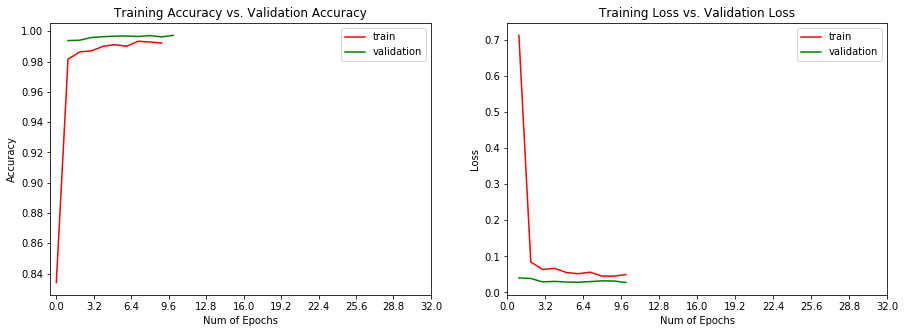

In [0]:
plot_model_history('model',model.history.history,32)

## Testing the model on Outside Data

### Captcha Preprocessing

The Captcha Text is 8746


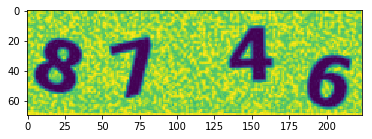

In [0]:
from skimage.transform import resize
img_size = 20

predictions = []

img = cv2.imread('captcha.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
image = cv2.copyMakeBorder(img,8,8,8,8,cv2.BORDER_REPLICATE)

thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contours = contours[0] if imutils.is_cv2() else contours[1]
letter_image_regions = []

for contour in contours:

    (x,y,w,h) = cv2.boundingRect(contour)
    if h == 0:
        print(x,y,w,h)
    if w/h > 1.25:

        half_width = int(w/2)
        letter_image_regions.append((x, y, half_width, h))
        letter_image_regions.append((x + half_width, y, half_width, h))

    else:
        letter_image_regions.append((x,y,w,h))

if len(letter_image_regions)>4:
    print('Sorry! but the captcha is more than 4 letters!!')

else:
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    for box,text in zip(letter_image_regions, correct_text):

        (x,y,w,h) = box

        letter_image = image[y-2: y+h+2,x-2:x+w+2]

        X = cv2.resize(letter_image, (img_width, img_height), interpolation = cv2.INTER_CUBIC)
        
        X = X.reshape(1,20,20,1).astype('float32')
        prediction = model.predict(X).argmax(axis = 1)[0]
        for key,value in mapping.items():
            if value == prediction:
                prediction = key
                break
        predictions.append(prediction)
    print(f"The Captcha Text is {''.join(predictions)}")